# NLP Challenge: Twitter Sentiment Analysis

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression
# from gensim.models import Word2Vec
# from gensim.test.utils import datapath
# from gensim import utils
# import gensim
import multiprocessing
cores = multiprocessing.cpu_count()
import os
from time import time
import torch
from transformers import AutoModel, AutoTokenizer, AutoConfig
from transformers import AutoModelForSequenceClassification
from torch.utils.data import DataLoader

In [2]:
# Import the machine learning model of your choice
from sklearn.linear_model import LogisticRegression
# Example: from sklearn.naive_bayes import MultinomialNB

In [ ]:
# To notify when cell is complete
!pip install git+https://github.com/cphyc/jupyter-notify.git
%reload_ext jupyternotify

# Step 1: Load the Sentiment140 dataset

In [4]:
# Download the dataset from Kaggle and specify the file path
df = pd.read_csv('../training.1600000.processed.noemoticon.csv', names=['target', 'id', 'date', 'flag', 'user', 'tweet'])
df.head()

,target,id,date,flag,user,tweet
0,0,1467810369,Mon Apr 06 22:19:45 PDT 2009,NO_QUERY,_TheSpecialOne_,"@switchfoot http://twitpic.com/2y1zl - Awww, t..."
1,0,1467810672,Mon Apr 06 22:19:49 PDT 2009,NO_QUERY,scotthamilton,is upset that he can't update his Facebook by ...
2,0,1467810917,Mon Apr 06 22:19:53 PDT 2009,NO_QUERY,mattycus,@Kenichan I dived many times for the ball. Man...
3,0,1467811184,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,ElleCTF,my whole body feels itchy and like its on fire
4,0,1467811193,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,Karoli,"@nationwideclass no, it's not behaving at all...."


# Step 2: Data Preprocessing

In [5]:
# Clean the text data, remove special characters, handle missing values, etc.
df.isnull().sum()

target    0
id        0
date      0
flag      0
user      0
tweet     0
dtype: int64

In [6]:
df.duplicated().sum()

0

In [7]:
# preprocess function, applying to df
def preprocess(text):
    new_text = []
    for t in text.split(" "):
        t = '@user' if t.startswith('@') and len(t) > 1 else t
        t = 'http' if t.startswith('http') else t
        new_text.append(t)
    return " ".join(new_text)
df['processed'] = df.tweet.map(lambda x: preprocess(x))

In [8]:
df = df.drop(columns=['date', 'flag', 'user', 'tweet'])

In [23]:
# Select 50,000 rows of each target value and merge for 100k rows
sampled_df = pd.concat([df[df['target'] == 0].head(50000),
                        df[df['target'] == 4].head(50000)])
sampled_df.reset_index(drop=True, inplace=True)
sampled_df.tail()

,target,id,processed
99995,4,1565294606,Now need 8 followers to compleate 1000 Follow...
99996,4,1565294669,I knew I had to explain something to my friend...
99997,4,1565294684,done tweeting..... til tomorrow..
99998,4,1565294704,@user Act II set is pretty breath-taking -Love...
99999,4,1565294736,if you don't have an artfire account to sell y...


# Pulling BERT from huggingface
tokenizer = AutoTokenizer.from_pretrained("activebus/BERT_Review")
model = AutoModel.from_pretrained("activebus/BERT_Review")# Step 3: Feature Extraction

In [11]:
# Pulling BERT from huggingface
tokenizer = AutoTokenizer.from_pretrained("activebus/BERT_Review")
model = AutoModel.from_pretrained("activebus/BERT_Review")

Some weights of the model checkpoint at activebus/BERT_Review were not used when initializing BertModel: ['cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.weight', 'cls.predictions.decoder.bias', 'cls.predictions.transform.dense.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [12]:
# Function to vectorize text with BERT
def get_embedding(text):
    text = preprocess(text)
    encoded_input = tokenizer(text, return_tensors='pt')
    features = model(**encoded_input)
    features = features[0].detach().numpy() 
    features_mean = np.mean(features[0], axis=0) 
    return features_mean

In [ ]:
# Applying function to dataframe
sampled_df['embeddings'] = sampled_df.processed.map(lambda x: get_embedding(x))

In [27]:
sampled_df.tail(2)

,target,id,processed,embeddings
99998,4,1565294704,@user Act II set is pretty breath-taking -Love...,"[0.17751333, 0.20428097, 0.4664867, 0.08462258..."
99999,4,1565294736,if you don't have an artfire account to sell y...,"[0.061174624, 0.39622757, 0.10942916, -0.07039..."


In [25]:
# Converting embeddings to numpy array
vectors = np.array(sampled_df.embeddings.tolist(), dtype='float')
# Flattening numpy array and building dataframe
v_df = pd.DataFrame(vectors, columns=[f'col{i+1}' for i in range(vectors.shape[1])])
v_df.head(2)

,col1,col2,col3,col4,col5,col6,col7,col8,col9,col10,...,col759,col760,col761,col762,col763,col764,col765,col766,col767,col768
0,-0.041625,0.328282,0.129892,0.113585,0.005617,-0.040401,0.174888,0.396562,-0.229657,0.212538,...,0.080155,-0.115446,-0.000836,-0.267958,-0.002265,0.033216,-0.144090,0.022695,0.272248,0.046899
1,-0.043312,0.364029,0.352331,0.015108,0.310784,-0.024684,0.179151,0.601353,-0.144423,-0.355677,...,0.137895,-0.102605,0.151654,-0.090540,0.104970,-0.249910,-0.157018,-0.172048,0.219015,-0.146118


In [28]:
# Joining the dataframes
combined = pd.concat([sampled_df, v_df], axis=1)
combined.head(1)

,target,id,processed,embeddings,col1,col2,col3,col4,col5,col6,...,col759,col760,col761,col762,col763,col764,col765,col766,col767,col768
0,0,1467810369,"@user http - Awww, that's a bummer. You shoul...","[-0.041624658, 0.328282, 0.12989177, 0.1135845...",-0.041625,0.328282,0.129892,0.113585,0.005617,-0.040401,...,0.080155,-0.115446,-0.000836,-0.267958,-0.002265,0.033216,-0.14409,0.022695,0.272248,0.046899


In [29]:
# Leaving text columns in X
X = combined.drop(columns=['target', 'id'])
y = combined['target']

In [1]:
# Choose a feature extraction method (e.g., TF-IDF, Gensim, or a pretrained language model) and transform the text data into numerical features.
# tfidf_vectorizer = TfidfVectorizer(max_features=5000, stop_words='english')
# X = tfidf_vectorizer.fit_transform(df['text'])
# y = df['target']
# YOUR CODE HERE!

# Step 4: Model Selection and Training

In [96]:
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)
# Snatching test data with text columns still in-place for later use (sentiment on twitter the company)
y_test_df = pd.DataFrame({'target': y_test}) # bulding dataframe for y_test to make pd.concat work
twit_test = pd.concat([y_test_df, X_test], axis=1)
# Needed these columns for twit_test, now we don't
X_train = X_train.drop(columns=['processed', 'embeddings'])
X_test = X_test.drop(columns=['processed', 'embeddings'])

In [97]:
twit_test.head(1)

,target,processed,embeddings,col1,col2,col3,col4,col5,col6,col7,...,col759,col760,col761,col762,col763,col764,col765,col766,col767,col768
75721,4,"home from L&amp;L, would rather work at night,...","[-0.023758927, 0.23790616, 0.14897163, -0.0332...",-0.023759,0.237906,0.148972,-0.03323,0.113582,-0.155933,0.231587,...,0.338975,0.128257,0.04227,0.134445,0.043902,-0.181062,-0.174875,-0.481493,0.090691,-0.054542


In [98]:
# Choose a machine learning model (e.g., Logistic Regression) and train it
Regression = LogisticRegression(max_iter=1000)
Regression.fit(X_train, y_train)

LogisticRegression(max_iter=1000)

In [99]:
print(f'Train score: , {Regression.score(X_train, y_train)}')
print(f'Test score: , {Regression.score(X_test, y_test)}')

Train score: , 0.8123466666666667
Test score: , 0.81056


# Step 5: Sentiment Analysis

In [100]:
# Perform sentiment analysis on the dataset using your trained model
y_pred = Regression.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.81      0.81      0.81     12528
           4       0.81      0.81      0.81     12472

    accuracy                           0.81     25000
   macro avg       0.81      0.81      0.81     25000
weighted avg       0.81      0.81      0.81     25000



In [101]:
# Selecting only tweets containing 'twitter'. Could not find any tweets containing AI-related companies in this sampled dataset.
twitter = twit_test[twit_test['processed'].str.contains('twitter', case=False, na=False)]
twitter.reset_index(drop=True, inplace=True)
twitter.tail(1)

,target,processed,embeddings,col1,col2,col3,col4,col5,col6,col7,...,col759,col760,col761,col762,col763,col764,col765,col766,col767,col768
789,4,@user One of the reasons we running a poll ove...,"[0.18864076, 0.31615606, 0.12423632, 0.0812644...",0.188641,0.316156,0.124236,0.081264,-0.095382,-0.238573,0.375081,...,-0.100441,-0.005507,-0.142958,-0.138373,0.034979,-0.097671,0.131727,-0.085034,0.388696,-0.192831


Using trained model to predict Anthropic tweets:

In [102]:
# processing twitter selection
twit_X = twitter.drop(columns=['target', 'processed', 'embeddings'])
twit_y = twitter['target']
# Make prediction with model
twit_y_pred = Regression.predict(twit_X)
print(classification_report(twit_y, twit_y_pred))

              precision    recall  f1-score   support

           0       0.72      0.73      0.72       252
           4       0.87      0.87      0.87       538

    accuracy                           0.82       790
   macro avg       0.79      0.80      0.80       790
weighted avg       0.82      0.82      0.82       790



# Step 6: Visualizations

In [126]:
# Select an AI company or product of your choice and collect tweets related to it
# Use your trained model to predict sentiment on these tweets
# Create visualizations to showcase sentiment (e.g., bar charts, word clouds)

# Example: 
# - Visualize sentiment distribution using seaborn or matplotlib.
# - Create word clouds for positive and negative tweets.
# - Generate a bar chart showing sentiment scores for the chosen company/product.

# Additional Tips:
# - Experiment with hyperparameter tuning to improve model performance.
# - Use cross-validation for a more robust evaluation.
# - Write functions to encapsulate repetitive tasks and improve code organization.

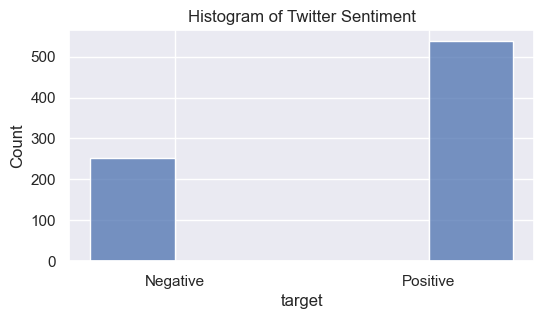

In [135]:
sns.set(rc={'figure.figsize': (6, 3)})
sns.histplot(data=twit_y, bins=[0, 4], discrete=True, stat="count", common_norm=False)

custom_labels = ['Negative', 'Positive']
plt.xticks([0.5, 3.5], custom_labels, rotation=0)
plt.title('Histogram of Twitter Sentiment')
plt.savefig('hist_twit_y.png')
plt.show()

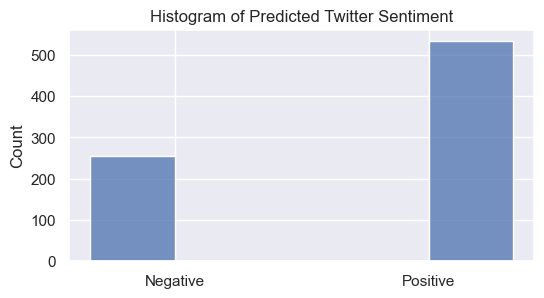

In [136]:
sns.set(rc={'figure.figsize': (6, 3)})
sns.histplot(data=twit_y_pred, bins=[0, 4], discrete=True, stat="count", common_norm=False)

custom_labels = ['Negative', 'Positive']
plt.xticks([0.5, 3.5], custom_labels, rotation=0)
plt.title('Histogram of Predicted Twitter Sentiment')
plt.savefig('hist_twit_y_pred.png')
plt.show()

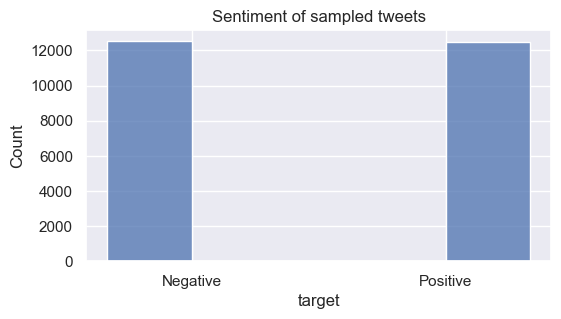

In [137]:
sns.set(rc={'figure.figsize': (6, 3)})
sns.histplot(data=y_test, bins=[0, 4], discrete=True, stat="count", common_norm=False)

custom_labels = ['Negative', 'Positive']
plt.xticks([0.5, 3.5], custom_labels, rotation=0)
plt.title('Sentiment of sampled tweets')
plt.savefig('hist_y_test.png')
plt.show()

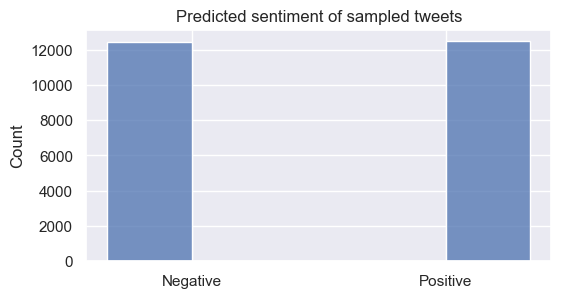

In [138]:
sns.set(rc={'figure.figsize': (6, 3)})
sns.histplot(data=y_pred, bins=[0, 4], discrete=True, stat="count", common_norm=False)

custom_labels = ['Negative', 'Positive']
plt.xticks([0.5, 3.5], custom_labels, rotation=0)
plt.title('Predicted sentiment of sampled tweets')
plt.savefig('hist_y_pred.png')
plt.show()

# Evaluation

In [109]:
# Evaluate your model's performance using metrics like accuracy, precision, recall, and F1-score.
print(f'accuracy: {accuracy_score(y_test, y_pred)}')
print(f'classification report: {classification_report(y_test, y_pred)}')
print(f'confusion matrix: {confusion_matrix(y_test, y_pred)}')

accuracy: 0.81056
classification report:               precision    recall  f1-score   support

           0       0.81      0.81      0.81     12528
           4       0.81      0.81      0.81     12472

    accuracy                           0.81     25000
   macro avg       0.81      0.81      0.81     25000
weighted avg       0.81      0.81      0.81     25000

confusion matrix: [[10132  2396]
 [ 2340 10132]]


In [110]:
# Performance on twitter
print(f'accuracy: {accuracy_score(twit_y, twit_y_pred)}')
print(f'classification report: {classification_report(twit_y, twit_y_pred)}')
print(f'confusion matrix: {confusion_matrix(twit_y, twit_y_pred)}')

accuracy: 0.8215189873417722
classification report:               precision    recall  f1-score   support

           0       0.72      0.73      0.72       252
           4       0.87      0.87      0.87       538

    accuracy                           0.82       790
   macro avg       0.79      0.80      0.80       790
weighted avg       0.82      0.82      0.82       790

confusion matrix: [[183  69]
 [ 72 466]]


---